# Feedforward with Attention

In [1]:
import pickle
import time
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from matplotlib import pyplot as plt
import math

from lstm_data_prep import numpy_prep
from eval_model import accuracy, find_lens, epoch_time
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
class FF(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_outputs):
    super().__init__()
    self.in_layer = nn.Linear(n_inputs, n_hidden)
    self.out_layer = nn.Linear(n_hidden, n_outputs)

    self.fc_h = nn.Linear(n_hidden, n_hidden, bias=False)
    self.fc_out = nn.Linear(n_hidden, n_hidden, bias=False)
    self.weight = nn.Parameter(torch.FloatTensor(n_hidden))

  def forward(self, x, batch_size):
    y = self.in_layer(x)

    # attention
    # (batch_size, seq_len, seq_len)
    e = torch.zeros((batch_size, y.shape[1], y.shape[1]), device=device)
    V = self.weight.repeat(batch_size, 1).unsqueeze(1)
    for i in range(y.shape[1]):
      r = torch.zeros(y.shape, device=device)
      for j in range(y.shape[1]):
        z = torch.tanh(self.fc_h(y[:, i, :]) + self.fc_out(y[:, j, :]))
        r[:, j, :] = z
      r = r.permute(0, 2, 1)
            
      a = torch.bmm(V, r).squeeze(1)
      e[:, i, :] = a.squeeze(1)
    att_weights = F.log_softmax(e, dim=-1)

    context_vector = torch.bmm(att_weights, y)
        
    y_hat = self.out_layer(context_vector)

    return y_hat

In [3]:
class FFModel:
  def __init__(self, model, loss_fn, optimizer, seq_len):
    self.model = model
    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.seq_len = seq_len
    
  def train(self, train_loader, n_epochs=500):
    train_loss = []
    best_loss = 1e10
    self.model.train()
    for i in range(n_epochs):
      start = time.time()
      avg_loss = 0.
      for X, y in train_loader:
        loss = 0.
        curr_batch_size = X.shape[0]
        X, y = X.to(device), y.to(device)
        self.optimizer.zero_grad()

        X_lens = find_lens(X)

        output = self.model(X, curr_batch_size)

        out = output.permute(0, 2, 1)
        target = y.permute(0, 2, 1)

        loss += self.loss_fn(out, target)
            
        loss.backward()
        self.optimizer.step()
        avg_loss += loss.item()

      end = time.time()

      epoch_mins, epoch_secs = epoch_time(start, end)
      if best_loss > avg_loss:
        best_loss = avg_loss
        torch.save({"ff_attention": self.model.state_dict(), "ff_att_optimizer": self.optimizer.state_dict()}, 'ff-attention-model.pt')

      print("Epoch " + str(i + 1) + "/" + str(n_epochs))
      print("Time: " + str(epoch_mins) + " minutes " + str(epoch_secs) + " seconds")
      print("Training loss: " + str(loss.item()))
      print()

      train_loss.append(avg_loss)
        
    return train_loss

  def eval(self, x, y):
    check = torch.load("ff-attention-model.pt")
    self.model.load_state_dict(check["ff_attention"])
    self.optimizer.load_state_dict(check["ff_att_optimizer"])
    with torch.no_grad():
      correct = np.zeros(self.seq_len)
      total = np.zeros(self.seq_len)
      self.model.eval()
      loss = 0.
      curr_batch_size = x.shape[0]
      X, Y = x.to(device), y.to(device)
      X_lens = find_lens(X)

      out = self.model(X, curr_batch_size)

      top_value, top_index = out.topk(1)

      final = torch.zeros(y.shape).to(device)
      for clip in range(y.shape[0]):
        for step in range(y.shape[1]):
          final[clip][step][top_index[clip][step]] = 1
            
      correct, total = accuracy(y.cpu().numpy(), final.cpu().numpy(), correct, total)
      ff_accuracy = correct / total
    return ff_accuracy, loss
  
  def random_samples(self, X, pad=0.):
    X_random = []
    X_lens = find_lens(X)
    for i in range(X.shape[0]):
      X_batch = np.random.rand(size=(X_lens[i], X.shape[-1]))
      if X_lens[i] < self.seq_len:
        X_pad = np.array([[pad]*X.shape[-1]]*(self.seq_len - X_lens[i]))
        X_batch = np.append(X_batch, X_pad, axis=0)
      X_random.append(X_batch)
    X_random = np.array(X_random)
    return X_random
    
  def rand_test(self, X, y_test, n_samples=20, percentile=90):
    rand_acc_array = []
    for sample in range(n_samples):
      X_random = torch.from_numpy(self.random_samples(X)).float().to(device)
      gru_rand_acc, _ = self.eval(X_random, y_test)
      rand_acc_array.append(gru_rand_acc)
    plot = np.percentile(np.sort(np.array(rand_acc_array), axis=0), percentile, axis=0)
    return plot


In [4]:
with open('HCP_movie_watching.pkl','rb') as f:
    TS = pickle.load(f)

X_train, y_train, X_t, y_t = numpy_prep(TS, pad = 0.)
batch_size = 32

train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

X_test = torch.from_numpy(X_t).float().to(device)
y_test = torch.from_numpy(y_t).float().to(device)

C:\Users\Anna\Documents\GitHub\srp-lab-notebook\hcp_data\lstm_data_prep.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_padded = paddingArr(np.array(X_arr), pad=pad)


In [5]:
EPOCHS = 15
n_input = 300
n_hidden = 32
n_output = 15
learning_rate = 2e-3
seq_len = 90

ff_attention = FF(n_input, n_hidden, n_output).to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(ff_attention.parameters(), lr=learning_rate)

model = FFModel(ff_attention, loss_fn, optimizer, seq_len)

In [6]:
train_loss = model.train(train_loader, n_epochs=EPOCHS)

Epoch 1/15
Time: 31 minutes 50 seconds
Training loss: 9.042702674865723

Epoch 2/15
Time: 29 minutes 50 seconds
Training loss: 10.118308067321777

Epoch 3/15
Time: 29 minutes 56 seconds
Training loss: 6.545799732208252

Epoch 4/15
Time: 29 minutes 34 seconds
Training loss: 7.093227863311768

Epoch 5/15
Time: 29 minutes 52 seconds
Training loss: 9.128828241955489e-05

Epoch 6/15
Time: 29 minutes 51 seconds
Training loss: 0.48530805110931396

Epoch 7/15
Time: 29 minutes 54 seconds
Training loss: 1.6071574687957764

Epoch 8/15
Time: 29 minutes 58 seconds
Training loss: 0.815249502658844

Epoch 9/15
Time: 29 minutes 38 seconds
Training loss: 1.130460262298584

Epoch 10/15
Time: 25 minutes 43 seconds
Training loss: 0.475784569978714

Epoch 11/15
Time: 29 minutes 33 seconds
Training loss: 0.005024053622037172

Epoch 12/15
Time: 29 minutes 54 seconds
Training loss: 0.8957090973854065

Epoch 13/15
Time: 29 minutes 53 seconds
Training loss: 0.11325562000274658

Epoch 14/15
Time: 29 minutes 52 s

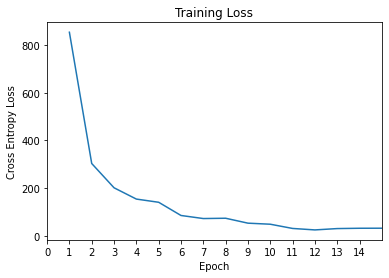

In [7]:
xAx = [i for i in range(1, EPOCHS+1)]
plt.plot(xAx, train_loss)
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.xlim(0, EPOCHS)
plt.xticks([j for j in range(EPOCHS)])
plt.title("Training Loss")
plt.show()

In [8]:
ff_accuracy, loss = model.eval(X_test, y_test)

In [9]:
ff_rand_acc = model.rand_test(X_test, y_test)

TypeError: rand() got an unexpected keyword argument 'size'

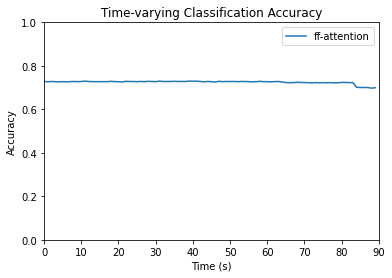

In [10]:
xAx = [i for i in range(0,90)]
plt.plot(xAx, ff_accuracy, label="ff-attention")
#plt.plot(xAx, ff_rand_acc, label="ff-att-random")
plt.xlabel("Time (s)")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.xlim(0,90)
plt.title("Time-varying Classification Accuracy")
plt.legend()
plt.show()